<a href="https://colab.research.google.com/github/dagraciar/cobertura_quemada/blob/main/an%C3%A1lisis_%C3%ADndice_nbr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análisis de áreas quemadas con Python

En este análisis, se utilizan datos satelitales recientes de Sentinel-2, accediendo a ellos a través del catálogo público STAC de Microsoft Planetary Computer. Se define el área de interés en La Calera, Colombia, y se realiza una búsqueda de imágenes con baja cobertura nubosa entre el 01 de enero y el 31 de mayo de 2025. A partir de los resultados obtenidos, se descargan las imágenes necesarias para su posterior análisis utilizando Python y librerías como rasterio y geopandas. Esta metodología permite identificar y mapear áreas afectadas por incendios mediante índices como el NBR (Índice de Quemado Normalizado), mostrando un análisis visual y cuantitativo de las hectáreas afectadas.

Paso 1: Definir el área de interés

Paso 2: Buscar imágenes de Sentinel-2 en el catálogo STAC

Paso 3: Visualizar la imagen RGB y reproyectarla

Paso 4: Revisión y recorte de imágenes reproyectadas

Paso 5: Recorte y reproyección de banda NIR

Paso 6: Cálculo de NBR

Paso 7: Histograma

Paso 8: Clasificación y estimación

Paso 9: Visualización

In [ ]:
# Instalación de librerías necesarias (solo ejecutar en notebooks locales)
!pip install planetary-computer pystac-client rasterio geopandas matplotlib --quiet

## Descarga de imágenes

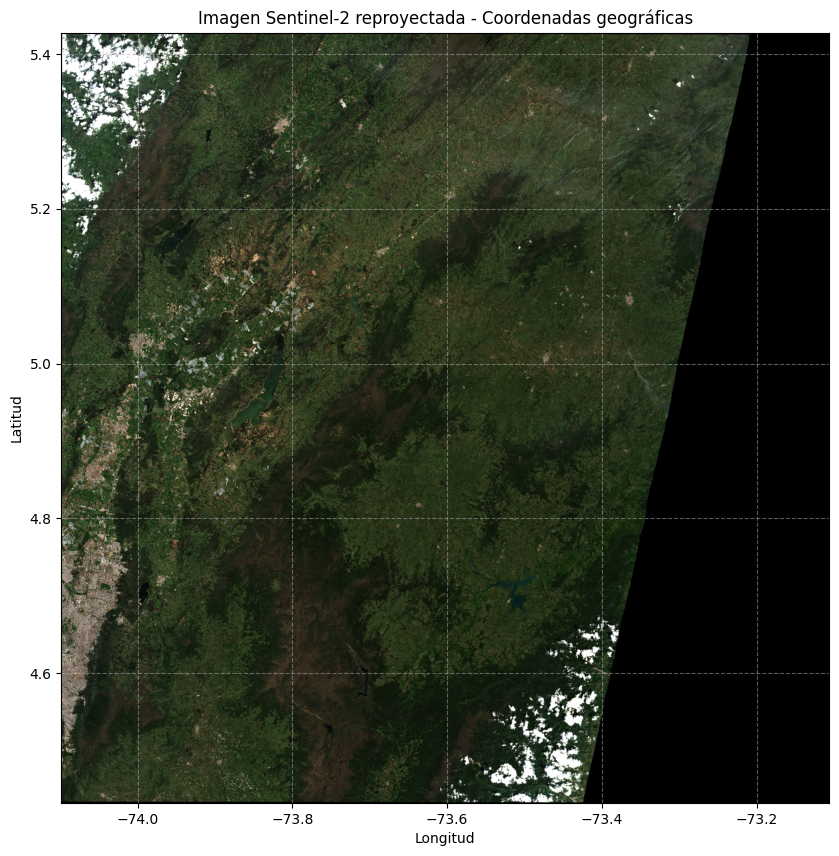

In [ ]:
# Importaciones
import planetary_computer as pc
import pystac_client
import rasterio
from rasterio.plot import show
from rasterio.enums import Resampling
from rasterio.warp import reproject, Resampling as WarpResampling, transform_bounds, calculate_default_transform
from rasterio.mask import mask
from shapely.geometry import box, mapping
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Paso 1: Definir área de interés (zona más pequeña para "zoom")
bounding_box = [-74.03, 4.66, -73.93, 4.74]
area_of_interest = box(*bounding_box)
gdf_aoi = gpd.GeoDataFrame({"geometry": [area_of_interest]}, crs="EPSG:4326")

# Paso 2: Buscar imágenes Sentinel-2 con baja nubosidad
stac_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
client = pystac_client.Client.open(stac_url)

search = client.search(
    collections=["sentinel-2-l2a"],
    bbox=bounding_box,
    datetime="2025-01-01/2025-05-31",
    query={"eo:cloud_cover": {"lt": 30}},
)

items = list(search.get_all_items())
item = min(items, key=lambda itm: itm.properties.get("eo:cloud_cover", float("inf")))
assets = item.assets

# Paso 3: Visualizar imagen RGB reproyectada con coordenadas geográficas
visual_href = pc.sign(assets["visual"].href)
with rasterio.open(visual_href) as dataset:
    dst_crs = "EPSG:4326"
    dst_transform, dst_width, dst_height = calculate_default_transform(
        dataset.crs, dst_crs, dataset.width, dataset.height, *dataset.bounds
    )
    dst = np.empty((3, dst_height, dst_width), dtype=dataset.dtypes[0])
    for i in range(1, 4):
        reproject(
            source=rasterio.band(dataset, i),
            destination=dst[i - 1],
            src_transform=dataset.transform,
            src_crs=dataset.crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=WarpResampling.nearest
        )
    fig, ax = plt.subplots(figsize=(10, 10))
    extent = (
        dst_transform[2],
        dst_transform[2] + dst_transform[0] * dst.shape[2],
        dst_transform[5] + dst_transform[4] * dst.shape[1],
        dst_transform[5]
    )
    ax.imshow(np.moveaxis(dst, 0, -1), extent=extent)
    ax.set_title("Imagen Sentinel-2 reproyectada - Coordenadas geográficas")
    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [ ]:
# Paso 4: Verificación robusta y recorte tolerante
swir_href = pc.sign(assets["B12"].href)
nir_href = pc.sign(assets["B08"].href)

with rasterio.open(swir_href) as swir_src:
    raster_bounds = swir_src.bounds
    raster_crs = swir_src.crs

    bbox_transformed = transform_bounds("EPSG:4326", raster_crs, *bounding_box, densify_pts=21)
    bbox_geom_raster_crs = box(*bbox_transformed)

    if not box(*raster_bounds).intersects(bbox_geom_raster_crs):
        raise ValueError("El bounding box no intersecta con los datos raster seleccionados.")

    try:
        swir_crop, swir_transform_crop = mask(
            swir_src,
            [mapping(area_of_interest)],
            crop=True
        )
    except ValueError:
        swir_crop, swir_transform_crop = mask(
            swir_src,
            [mapping(bbox_geom_raster_crs)],
            crop=True
        )

    swir = swir_crop[0].astype('float32')
    swir_transform = swir_transform_crop

In [ ]:
# Paso 5: Recorte y reproyección de la banda NIR
with rasterio.open(nir_href) as nir_src:
    nir_resampled = np.empty_like(swir, dtype='float32')
    reproject(
        source=rasterio.band(nir_src, 1),
        destination=nir_resampled,
        src_transform=nir_src.transform,
        src_crs=nir_src.crs,
        dst_transform=swir_transform,
        dst_crs=raster_crs,
        resampling=WarpResampling.bilinear
    )
    nir = nir_resampled

# Paso 6: Calcular NBR
sum_array = nir + swir
valid_mask = (sum_array != 0) & (~np.isnan(nir)) & (~np.isnan(swir))
nbr = np.full_like(nir, np.nan, dtype="float32")
nbr[valid_mask] = (nir[valid_mask] - swir[valid_mask]) / sum_array[valid_mask]

## Cálculo de hectáreas quemadas según NBR

$\text{NBR} = \frac{\text{NIR} - \text{SWIR}}{\text{NIR} + \text{SWIR}}$

Donde:

NIR es la banda infrarroja cercana (Near Infrared).

SWIR es la banda infrarroja de onda corta (Shortwave Infrared).

Es una primera aproximación. Se sugiere calibrar el umbral con valores validados con datos a campo.


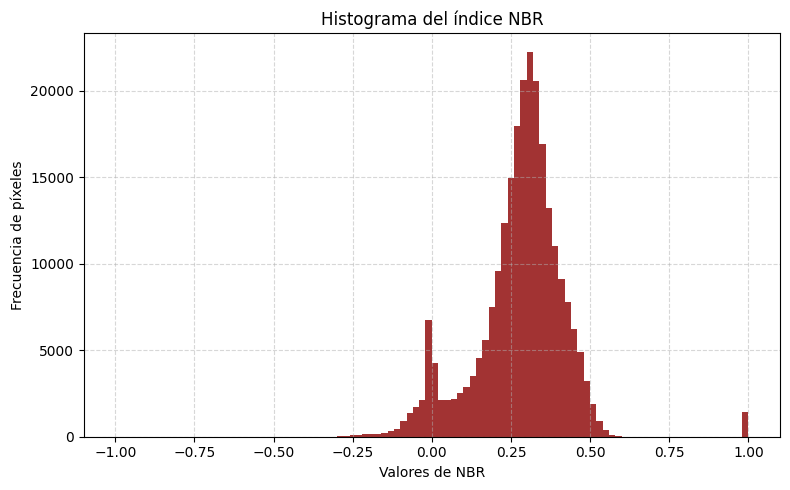

Área quemada estimada: 4.80 hectáreas


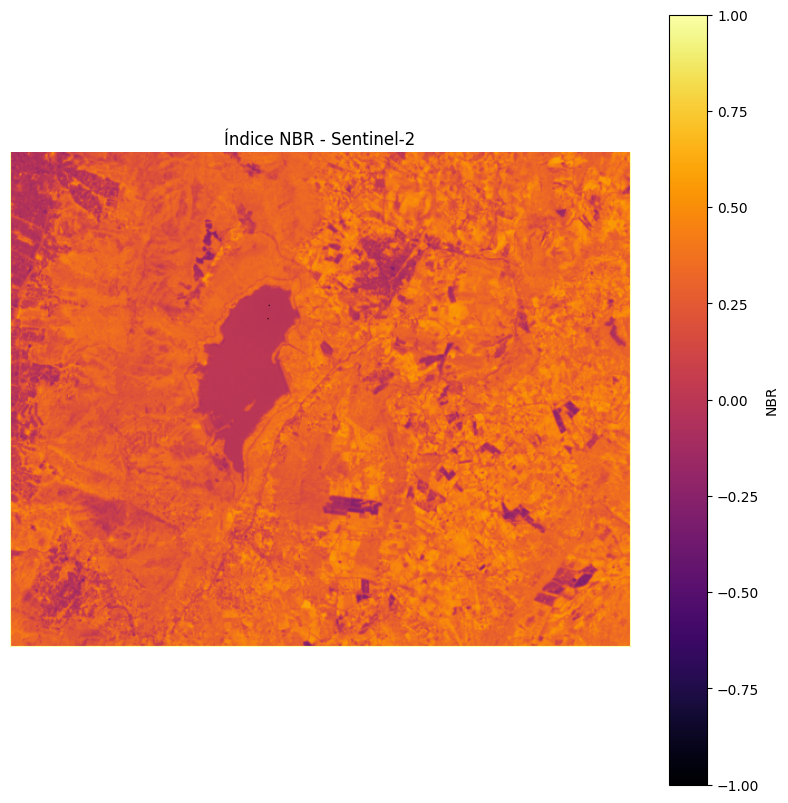

In [ ]:
# Paso 7: Histograma del índice NBR
plt.figure(figsize=(8, 5))
plt.hist(nbr[~np.isnan(nbr)].flatten(), bins=100, color='darkred', alpha=0.8)
plt.title("Histograma del índice NBR")
plt.xlabel("Valores de NBR")
plt.ylabel("Frecuencia de píxeles")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Paso 8: Clasificación de área quemada y estimación
threshold = -0.25
burnt_area = np.where(nbr < threshold, 1, 0)

pixel_size = 20  # metros
area_m2 = burnt_area.sum() * (pixel_size ** 2)
area_ha = area_m2 / 10_000
print(f"Área quemada estimada: {area_ha:.2f} hectáreas")

# Paso 9: Visualización del índice NBR
plt.figure(figsize=(10, 10))
plt.imshow(nbr, cmap='inferno')
plt.colorbar(label="NBR")
plt.title("Índice NBR - Sentinel-2")
plt.axis('off')
plt.show()

## Visualización NBR